In [1]:
import pandas as pd
data = pd.read_csv("./data.csv")
data.head()

,Mois,Date de l'incident,Ligne,Lieu,Description de l'incident,Nombre de minutes de retard,Nombre de trains supprimés,Saison
0,septembre,2025-09-26,59,ANTWERPEN-ZUID,Intrusion dans les voies,1051,29,automne
1,septembre,2025-09-22,161,BOSVOORDE,Obstacle dans/à proximité de la voie,1588,74,automne
2,septembre,2025-09-17,161,MONT-SAINT-GUIBERT,Avarie matériel roulant,1083,37,automne
3,septembre,2025-09-15,60,DENDERMONDE,Dérangement à la signalisation,1288,12,automne
4,septembre,2025-09-11,50A,BEERNEM,Heurt d'une personne,3755,70,automne


On veut vérifier si il y a un lien entre les lignes; les lieux; les saisons et les retards sur le réseau

## Par ligne

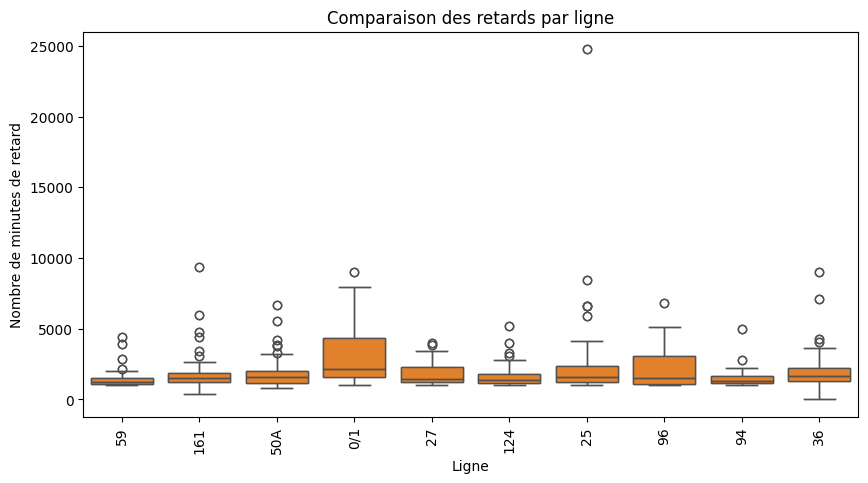

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ne garder que les 10 lignes les plus représentées
top_lignes = data["Ligne"].value_counts().head(10).index
subset = data[data["Ligne"].isin(top_lignes)]

plt.figure(figsize=(10,5))
sns.boxplot(x=subset["Ligne"], y=subset["Nombre de minutes de retard"])
plt.xticks(rotation=90)
plt.title("Comparaison des retards par ligne")
sns.boxplot(x="Ligne", y="Nombre de minutes de retard", data=subset)
plt.show()

La plupart des lignes ont des médianes et des boîtes de tailles similaires, donc les retards ne varient pas beaucoup d’une ligne à l’autre. Pour une meilleure visualisation, essayons de tracer une bar chart du retard moyen par ligne.

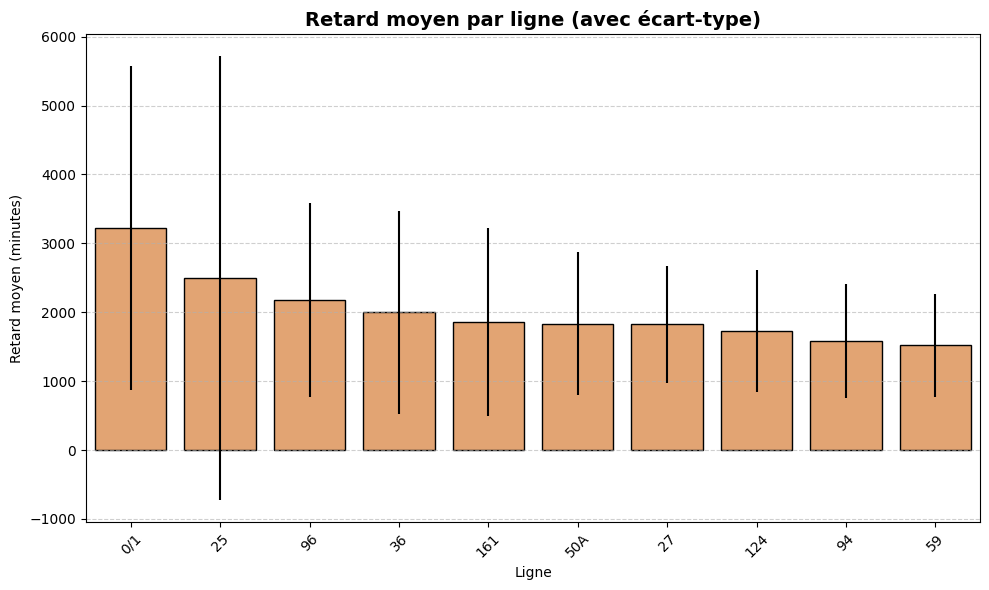

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calcul du retard moyen et de l'écart-type par ligne
retard_stats = (
    subset.groupby("Ligne")["Nombre de minutes de retard"]
      .agg(["mean", "std", "count"])
      .reset_index()
      .sort_values("mean", ascending=False)
)

# Tracer le bar chart avec barres d'erreur
plt.figure(figsize=(10,6))
sns.barplot(
    data=retard_stats,
    x="Ligne", y="mean", 
    yerr=retard_stats["std"],
    color="#F4A261", edgecolor="black"
)
plt.title("Retard moyen par ligne (avec écart-type)", fontsize=14, fontweight="bold")
plt.xlabel("Ligne")
plt.ylabel("Retard moyen (minutes)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Essayons maintenant de vérifier celà sur l'ensemble de nos données en utilisant le test ANOVA et le test Kruskal

In [16]:
from scipy.stats import f_oneway, kruskal

f_stat, p_val = f_oneway(
    *[data[data["Ligne"] == ligne]["Nombre de minutes de retard"] for ligne in data["Ligne"].unique()]
)
h, p_kw = kruskal(
    *[data[data["Ligne"] == s]["Nombre de minutes de retard"] for s in data["Ligne"].unique()]
)

print("Anova :", p_val)
print("Krustal :", p_kw)
print("p > 0.05:", p_val > 0.05 and p_kw > 0.05)

Anova : 0.22368578327506933
Krustal : 0.05350430206618845
p > 0.05: True


On peut conclure qu'il n'y a aucune différence significative entre les retards au niveau de chaque ligne.

## Par lieux

In [21]:
f_stat, p_val = f_oneway(
    *[data[data["Lieu"] == ligne]["Nombre de trains supprimés"] for ligne in data["Lieu"].unique()]
)
h, p_kw = kruskal(
    *[data[data["Lieu"] == s]["Nombre de trains supprimés"] for s in data["Lieu"].unique()]
)

print("Anova :", p_val)
print("Krustal :", p_kw)
print("p > 0.05:", p_val > 0.05 and p_kw > 0.05)

Anova : 0.994290945852665
Krustal : 0.0020409063941911458
p > 0.05: False


Avec le test d'Anova on peut penser qu'il n'y a aucune relation entre les lieux et les incidents mais le test de Krustal dit autre chose. Nous allons donc continuer à explorer cette hypothèse

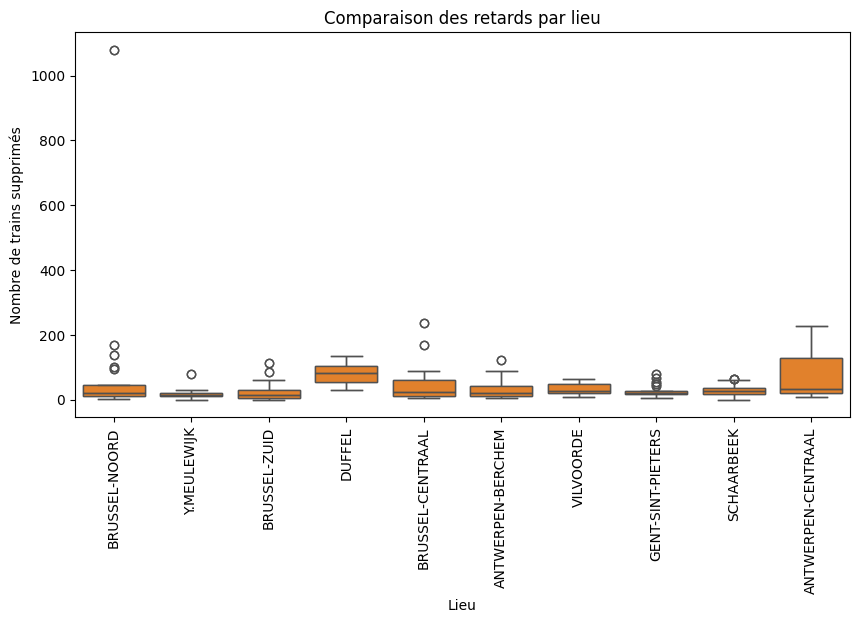

In [23]:
# Ne garder que les 10 lieux les plus représentés
top_lieux = data["Lieu"].value_counts().head(10).index
subset = data[data["Lieu"].isin(top_lieux)]

plt.figure(figsize=(10,5))
sns.boxplot(x=subset["Lieu"], y=subset["Nombre de trains supprimés"])
plt.xticks(rotation=90)
plt.title("Comparaison des retards par lieu")
sns.boxplot(x="Lieu", y="Nombre de trains supprimés", data=subset)
plt.show()

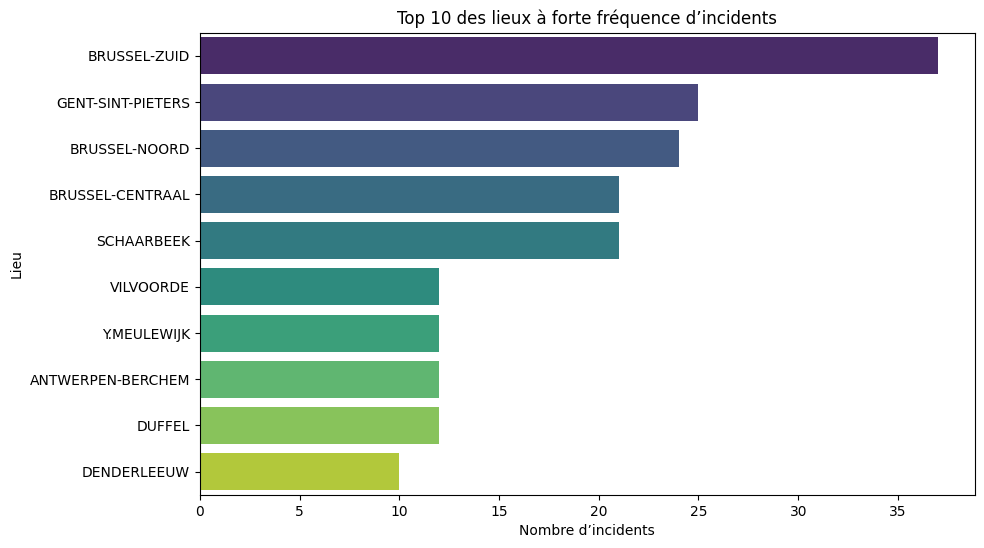

In [25]:
top_lieux = data.groupby("Lieu")["Description de l'incident"].count().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_lieux.values, y=top_lieux.index, palette="viridis", hue=top_lieux.index, legend=False)
plt.title("Top 10 des lieux à forte fréquence d’incidents")
plt.xlabel("Nombre d’incidents")
plt.ylabel("Lieu")
plt.show()

## Par saison

In [18]:
f_stat, p_val = f_oneway(
    *[data[data["Saison"] == ligne]["Nombre de minutes de retard"] for ligne in data["Saison"].unique()]
)
h, p_kw = kruskal(
    *[data[data["Saison"] == s]["Nombre de minutes de retard"] for s in data["Saison"].unique()]
)

print("Anova :", p_val)
print("Krustal :", p_kw)
print("p > 0.05:", p_val > 0.05 and p_kw > 0.05)

Anova : 0.05748324874987672
Krustal : 0.06556261037755849
p > 0.05: True


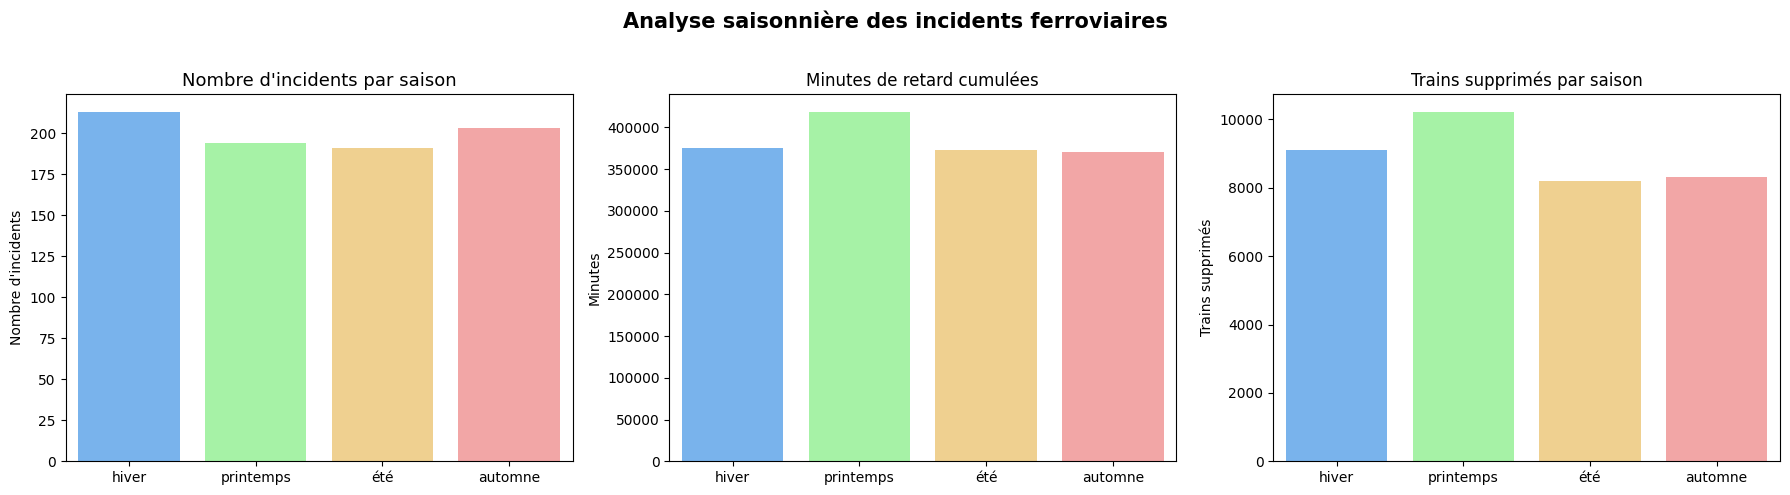

In [26]:
# Regrouper les indicateurs saisonniers
saison_kpi = data.groupby("Saison").agg({
    "Nombre de minutes de retard": "sum",
    "Nombre de trains supprimés": "sum",
    "Description de l'incident": "count"
}).rename(columns={"Description de l'incident": "Nombre d'incidents"}).reset_index()

# Ordonner les saisons pour plus de cohérence visuelle
ordre_saisons = ["hiver", "printemps", "été", "automne"]
saison_kpi["Saison"] = pd.Categorical(saison_kpi["Saison"], categories=ordre_saisons, ordered=True)
saison_kpi = saison_kpi.sort_values("Saison")

# Palette personnalisée (mieux visuellement)
couleurs = ["#66B3FF", "#99FF99", "#FFD580", "#FF9999"]

# Créer 3 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Nombre d'incidents par saison
sns.barplot(
    data=saison_kpi,
    x="Saison", y="Nombre d'incidents", palette=couleurs, hue="Saison", legend=False, ax=axes[0]
)
axes[0].set_title("Nombre d'incidents par saison", fontsize=13)
axes[0].set_ylabel("Nombre d'incidents")
axes[0].set_xlabel("")

# Minutes de retard cumulées par saison
sns.barplot(
    data=saison_kpi,
    x="Saison", y="Nombre de minutes de retard", palette=couleurs, hue="Saison", legend=False, ax=axes[1]
)
axes[1].set_title("Minutes de retard cumulées")
axes[1].set_ylabel("Minutes")
axes[1].set_xlabel("")

# Nombre de trains supprimés par saison
sns.barplot(
    data=saison_kpi,
    x="Saison", y="Nombre de trains supprimés", palette=couleurs, hue="Saison", legend=False, ax=axes[2]
)
axes[2].set_title("Trains supprimés par saison")
axes[2].set_ylabel("Trains supprimés")
axes[2].set_xlabel("")

# Ajustement global
plt.suptitle("Analyse saisonnière des incidents ferroviaires", fontsize=15, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [19]:
f_stat, p_val = f_oneway(
    *[data[data["Mois"] == ligne]["Nombre de minutes de retard"] for ligne in data["Mois"].unique()]
)
h, p_kw = kruskal(
    *[data[data["Mois"] == s]["Nombre de minutes de retard"] for s in data["Mois"].unique()]
)

print("Anova :", p_val)
print("Krustal :", p_kw)
print("p > 0.05:", p_val > 0.05 and p_kw > 0.05)

Anova : 0.011953530729770493
Krustal : 0.03253093007354474
p > 0.05: False


Ici on remarque que la fréquence des incidents diffère selon les moins mais ceci est moins évidents selon les saisons.